<a href="https://colab.research.google.com/github/atstuyuki/ScikitLearn/blob/main/mediapipe_throwing2D3D_toCSV20220607.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# セットアップ

In [ ]:
#google driveのマウント
'''from google.colab import drive
drive.mount('/content/drive')'''

"from google.colab import drive\ndrive.mount('/content/drive')"

In [ ]:
# ライブラリーのインストール
!pip install numpy==1.19.3
!pip install mediapipe
# 初期設定 holistic とPoseを用意する　検出感度は0.5＞＞変更可能
import mediapipe as mp
import cv2
mp_holistic = mp.solutions.holistic
mp_pose = mp.solutions.pose
# Initialize MediaPipe Holistic.
holistic = mp_holistic.Holistic(
    static_image_mode=True, min_detection_confidence=0.3)
pose= mp_pose.Pose(
    static_image_mode=True, min_detection_confidence=0.3)
# Prepare DrawingSpec for drawing the face landmarks later.
mp_drawing = mp.solutions.drawing_utils 
drawing_spec = mp_drawing.DrawingSpec(color=[225,0,200],thickness=2, circle_radius=1) #color=[B,G,R]で指定,線の太さと〇の色も指定可能

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 14.9 MB 5.4 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray-einstats 0.2.2 requires numpy>=1.21, but you have numpy 1.19.3 which is incompatible.
tensorflow 2.8.2+zzzcolab20220527125636 requires numpy>=1.20, but you have numpy 1.19.3 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 32.8 MB 1.4 MB/s 


In [ ]:
#手元の動画をgoogle colabにupload

from google.colab import files
import os
uploaded = files.upload()
#uploadedは辞書型なのでファイル名を取り出し、絶対パスを取得してfullpathという変数を当てる
for k in uploaded.keys():
  print('file name:',k)
fullpath=os.path.abspath(k)
print('fullpath:',fullpath)

Saving #90-90-30-1.mp4 to #90-90-30-1.mp4
file name: #90-90-30-1.mp4
fullpath: /content/#90-90-30-1.mp4


In [ ]:
cap = cv2.VideoCapture(fullpath) #動画の読み込み
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)) #幅
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)) #高
frame_rate = int(cap.get(cv2.CAP_PROP_FPS)) #FPS
fourcc = cv2.VideoWriter_fourcc('m','p','4','v') #mp4出力
out = cv2.VideoWriter('out.mp4', fourcc, frame_rate, (width, height))

#3次元座標の角度計算の定義
def calculate_3D_angle(a,b,c):
    a = np.array(a) # First
    b = np.array(b) # Mid
    c = np.array(c) # End
    #0がx座標　１がｙ座標　２がｚ座標
    #ベクトルを定義 長さと内積からコサインを計算
    vec_a=a-b
    vec_c=c-b
    len_vec_a=np.linalg.norm(vec_a)
    len_vec_c=np.linalg.norm(vec_c)
    inner_product=np.inner(vec_a, vec_c)
    cos=inner_product/(len_vec_a*len_vec_c)
    
    #角度（ラジアン）の計算
    rad=np.arccos(cos)
    
    #ラジアンから度数へ変換
    angle=np.rad2deg(rad)
        
    return angle

#2次元からの角度計算の定義
def calculate_2D_angle(a,b,c):
  a=np.array(a)#firtst
  b=np.array(b)#second
  c=np.array(c)#third
  #[x,y,z]座標から[x,y]のみスライスしてベクトルを作成
  vec_a=a[0:2]-b[0:2]
  vec_c=c[0:2]-b[0:2]
  len_vec_a=np.linalg.norm(vec_a)
  len_vec_c=np.linalg.norm(vec_c)
  inner_product=np.inner(vec_a, vec_c)
  cos=inner_product/(len_vec_a*len_vec_c)
    
#角度（ラジアン）の計算
  rad=np.arccos(cos)
#ラジアンから度数へ変換
  angle=np.rad2deg(rad)
        
  return angle


# サンプルビデオの読み込み＋静止画に分解

In [ ]:
# video2images
import os
import shutil
import cv2

# 既にimagesフォルダーがあれば削除
if os.path.isdir('images'):
    shutil.rmtree('images')

os.makedirs('images', exist_ok=True)
 
def video_2_images(video_file= fullpath,   
                   image_dir='./images/', 
                   image_file='%s.png'):
 
    # Initial setting
    i = 0
    interval = 1#適宜調整
    length = 3500
    
    cap = cv2.VideoCapture(video_file)
    while(cap.isOpened()):
        flag, frame = cap.read()  
        if flag == False:  
                break
        if i == length*interval:
                break
        if i % interval == 0:    
           cv2.imwrite(image_dir+image_file % str(int(i/interval)).zfill(6), frame)
        i += 1 
    cap.release()  
 
def main():
    video_2_images()
    
if __name__ == '__main__':
    main()

In [ ]:
#pose_landmarkのリストを取得して配列に変換
import numpy as np
landmarklist=[]#空の配列を作成
for index in range(len(mp_holistic.PoseLandmark)):
    landmarklist.append(mp_holistic.PoseLandmark(index).name+'_x')
    landmarklist.append(mp_holistic.PoseLandmark(index).name+'_y')
    landmarklist.append(mp_holistic.PoseLandmark(index).name+'_z')
    landmarklist.append(mp_holistic.PoseLandmark(index).name+'_visibility')
#リストをarrayに変換
landmarklist=np.array(landmarklist).reshape(1,-1)
#landmarkshape の内容の確認
"""print(landmarklist.dtype)
print(landmarklist)
print(landmarklist.shape)"""

'print(landmarklist.dtype)\nprint(landmarklist)\nprint(landmarklist.shape)'

# MediaPipeで静止画を処理

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import glob
import time
#変数の初期化
rtelbowAnglelist=[]
rtshoulderAnglelist=[]
rtshoulderAbductionlist=[]
rtelbow_3DAnglelist=[]
rtshoulder_3DAnglelist=[]
rtshoulder_3DAbductionlist=[]
timelist=[]
data_land = np.zeros((0,132))

# image file names to files in list format
files=[]
for name in sorted(glob.glob('./images/*.png')):
    files.append(name)

# Read images with OpenCV.
images = {name: cv2.imread(name) for name in files}
w = width             # 画像の横幅を取得
h = height            # 画像の縦幅を取得

for name, image in images.items():
  # Convert the BGR image to RGB and process it with MediaPipe Pose.
  if image is None:
      break
  results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  landmarks = results.pose_landmarks
  if landmarks is None:
      print(name)
      continue
   #各検出ポイントをarrayに変換
  rtshoulder=[results.pose_landmarks.landmark[12].x,results.pose_landmarks.landmark[12].y,results.pose_landmarks.landmark[12].z]
  rtelbow=[results.pose_landmarks.landmark[14].x,results.pose_landmarks.landmark[14].y,results.pose_landmarks.landmark[14].z]
  rtwrist=[results.pose_landmarks.landmark[16].x,results.pose_landmarks.landmark[16].y,results.pose_landmarks.landmark[16].z]
  rthip=[results.pose_landmarks.landmark[24].x,results.pose_landmarks.landmark[24].y,results.pose_landmarks.landmark[24].z]
  ltshoulder=[results.pose_landmarks.landmark[11].x,results.pose_landmarks.landmark[11].y,results.pose_landmarks.landmark[11].z]
  #3D座標から角度を計算 2Dか3Dか選ぶ
  #rtelbowAngleは右肩-右肘-右手関節
  rtelbowAngle=180-calculate_2D_angle(rtshoulder,rtelbow,rtwrist)
  rtelbow_3DAngle=180-calculate_3D_angle(rtshoulder,rtelbow,rtwrist)
  #rtshoulderAngleは左肩-右肩-右肘
  rtshoulderAngle=calculate_2D_angle(ltshoulder,rtshoulder,rtelbow)
  rtshoulder_3DAngle=calculate_3D_angle(ltshoulder,rtshoulder,rtelbow)
  #rtshoulderAbductionは右股関節-右肩-右肘
  rtshoulderAbduction=calculate_2D_angle(rthip,rtshoulder,rtelbow)
  rtshoulder_3DAbduction=calculate_3D_angle(rthip,rtshoulder,rtelbow)
  #角度情報をテキストして画像に挿入
  cv2.putText(image, 'rtElbow'+str(round(rtelbowAngle,1)),
              (200,400),
              #tuple(np.multiply(rtelbow[:2],[w, h]).astype(int)),
              cv2.FONT_HERSHEY_SIMPLEX,0.5,(55,0,50),1,cv2.LINE_AA)

  cv2.putText(image, 'rtshoulderAbd'+str(round(rtshoulderAbduction,1)),
              (200,350),
              #tuple(np.multiply(rtshoulder[:2],[w, h]).astype(int)),
              cv2.FONT_HERSHEY_SIMPLEX,0.5,(55,0,50),1,cv2.LINE_AA)
  cv2.putText(image, 'rtshoulderAngle'+str(round(rtshoulderAngle,1)),
              (200,300),
              #tuple(np.multiply(rtshoulder[:2],[w, h]).astype(int)),
              cv2.FONT_HERSHEY_SIMPLEX,0.5,(55,0,50),1,cv2.LINE_AA)
  
  cv2.putText(image, 'rtElbow3D_'+str(round(rtelbow_3DAngle,1)),
              (400,400),
              #tuple(np.multiply(rtelbow[:2],[w, h]).astype(int)),
              cv2.FONT_HERSHEY_SIMPLEX,0.5,(255,0,250),1,cv2.LINE_AA)

  cv2.putText(image, 'rtShoulderAbd_3D_'+str(round(rtshoulder_3DAbduction,1)),
              (400,350),
              #tuple(np.multiply(rtshoulder[:2],[w, h]).astype(int)),
              cv2.FONT_HERSHEY_SIMPLEX,0.5,(255,0,250),1,cv2.LINE_AA)
  cv2.putText(image, 'rtshoulderAngle_3D_'+str(round(rtshoulder_3DAngle,1)),
              (400,300),
              #tuple(np.multiply(rtshoulder[:2],[w, h]).astype(int)),
              cv2.FONT_HERSHEY_SIMPLEX,0.5,(255,0,250),1,cv2.LINE_AA)

        
  rtelbowAnglelist.append(rtelbowAngle)
  rtshoulderAnglelist.append(rtshoulderAngle)  
  rtshoulderAbductionlist.append(rtshoulderAbduction)
  rtelbow_3DAnglelist.append(rtelbow_3DAngle)
  rtshoulder_3DAnglelist.append(rtshoulder_3DAngle)  
  rtshoulder_3DAbductionlist.append(rtshoulder_3DAbduction)
  timelist.append(time.time())
  # Draw pose landmarks.
  annotated_image = image.copy()
  # Get Landmarks
  #landmarks=results.pose_landmarks.landmark
 
  """
  Holisticを使用しない場合はこの部分をコメントアウト
  
  mp_drawing.draw_landmarks(annotated_image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
  mp_drawing.draw_landmarks(annotated_image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
  mp_drawing.draw_landmarks(
      image=annotated_image, 
      landmark_list=results.face_landmarks, 
      connections=mp_holistic.FACEMESH_TESSELATION,
      landmark_drawing_spec=drawing_spec,
      connection_drawing_spec=drawing_spec)
  """
  mp_drawing.draw_landmarks(
        image=annotated_image, 
        landmark_list=results.pose_landmarks, 
        connections=mp_pose.POSE_CONNECTIONS,
        landmark_drawing_spec=drawing_spec,
        connection_drawing_spec=drawing_spec)
  #get coordinate poseの33か所の3次元座標データと確信度(visibilisty)をすべて結合してCSVに変換
  data_land2 = np.zeros((1,3))
    
  for x in range (0,33):#pose_landmarksかpose_world_landmarksか選ぶ
      data1 = results.pose_landmarks.landmark[x].x
      data2 = results.pose_landmarks.landmark[x].y
      data3 = results.pose_landmarks.landmark[x].z
      data4 = results.pose_landmarks.landmark[x].visibility
      keydata = np.hstack((data1,data2,data3,data4)).reshape(1,-1)
      data_land2 = np.hstack((data_land2,keydata))

  data_land2 = data_land2[:,3:]
  data_land = np.vstack((data_land,data_land2))
  final_data= np.vstack((landmarklist,data_land))
  cv2.imwrite(name, annotated_image)  

#savetxtではデータの型が合わないと保存でき無いことがあるのでfmtで文字の型を指定
  np.savetxt('keypoint_results.csv',final_data,delimiter = ',',fmt = '%s')


./images/000000.png
./images/000019.png
./images/000022.png
./images/000023.png
./images/000028.png


# 角度のグラフ表示とデータのCSV保存

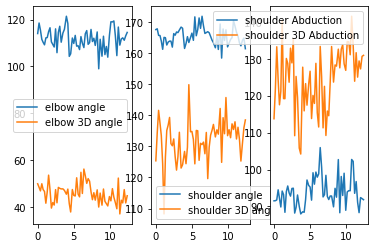

In [ ]:

from matplotlib import pyplot as plt
#combine Anglelist arrayにして水平結合
#timelistの開始数字を0に変更
np.array(timelist[0])
d=np.full(len(timelist),timelist[0])#すべての要素がtimelistの１番目の値でlen(timelist)の行列を作成
#timelistの時間を初期化（1番目の要素を0として行列の引き算
deltatime=np.array(timelist)-np.full(len(timelist),timelist[0])
a=np.array(rtelbowAnglelist)
b=np.array(rtshoulderAnglelist)
c=np.array(rtshoulderAbductionlist)
a1=np.array(rtelbow_3DAnglelist)
b1=np.array(rtshoulder_3DAnglelist)
c1=np.array(rtshoulder_3DAbductionlist)
# １つ目のプロット
plt.subplot(1,3,1)
plt.plot(deltatime,a, label='elbow angle')
plt.plot(deltatime,a1, label='elbow 3D angle')
plt.legend()

# 2つ目のプロット
plt.subplot(1,3,2)
plt.plot(deltatime,b, label='shoulder angle')
plt.plot(deltatime,b1, label='shoulder 3D angle')
plt.legend()
#3つ目のプロット
plt.subplot(1,3,3)
plt.plot(deltatime,c, label='shoulder Abduction')
plt.plot(deltatime,c1, label='shoulder 3D Abduction')
plt.legend()

plt.show() 
#角度データをAngle＿Results.CSVとして保存
name=['time','elbow_angle', 'shoulder_angle', 'shoulder_Abduction',
      'elbow_3D_angle','shoulder_3D_angle','shoulder_3D_Abduction']
data=np.stack((deltatime,a,b,c,a1,b1,c1)).T
data=np.vstack((name,data))
np.savetxt('Angle_Results.csv',data,delimiter = ',',fmt = '%s')

In [ ]:
#plotlyでグラフを可視化
import plotly
import plotly.graph_objs as go
# Google Colab. やJupyter Lab.でプロットするためには，以下を実行する．
import plotly.io as pio
pio.renderers.default = "colab"
#plotly.__version__

fig = go.Figure() # 1 

fig.add_trace(    #2. グラフを追加・記述する
    go.Scatter(x = deltatime, y = a,
                  name='elbow angle'))
fig.add_trace(
    go.Scatter(x= deltatime, y =b, name='shoulder angle'))
fig.add_trace(
    go.Scatter(x=deltatime, y= c, name='shoulder abduction'))
fig.add_trace(    #2. グラフを追加・記述する
    go.Scatter(x = deltatime, y = a1,
                  name='elbow 3D angle'))
fig.add_trace(
    go.Scatter(x= deltatime, y =b1, name='shoulder 3D angle'))
fig.add_trace(
    go.Scatter(x=deltatime, y= c1, name='shoulder 3D abduction'))

fig.update_layout( #3. グラフの装飾、制限を追加(titleの表示、x軸の最大値など)
    title = 'Joint angles over time',
    xaxis_title = 'time',
    yaxis_title = 'angle',
    showlegend = True
)
fig.show() #4.グラフの描画

In [ ]:
#keypoint_results.csvをデータフレームとして読み込む
import pandas as pd
df=pd.read_csv('keypoint_results.csv',sep=',',encoding='UTF-8')



In [ ]:
#右股関節　右肘　右肩　右手関節の座標のみ抽出
df_ltShoulder=df.iloc[:,44:47]
df_rtShoulder=df.iloc[:,48:51]
df_rtElbow=df.iloc[:,56:59]
df_rtWrist=df.iloc[:,64:67]
df_rtHip=df.iloc[:,96:99]

In [ ]:
lt_shoulder_x=df.iloc[:,44]
lt_shoulder_y=df.iloc[:,45]
lt_shoulder_z=df.iloc[:,46]
rt_shoulder_x=df.iloc[:,48]
rt_shoulder_y=df.iloc[:,49]
rt_shoulder_z=df.iloc[:,50]
rt_elbow_x=df.iloc[:,56]
rt_elbow_y=df.iloc[:,57]
rt_elbow_z=df.iloc[:,58]
rt_wrist_x=df.iloc[:,64]
rt_wrist_y=df.iloc[:,65]
rt_wrist_z=df.iloc[:,66]
rt_hip_x=df.iloc[:,96]
rt_hip_y=df.iloc[:,97]
rt_hip_z=df.iloc[:,98]

In [ ]:
fig = go.Figure() # 1 

fig.add_trace(    #2. グラフを追加・記述する
    go.Scatter(x = deltatime, y = lt_shoulder_x,
                  name='lt_shoulder_x'))
fig.add_trace(
    go.Scatter(x= deltatime, y =lt_shoulder_y, name='lt_shoulder_y'))
fig.add_trace(
    go.Scatter(x=deltatime, y= lt_shoulder_z, name='lt_shoulder_z'))
fig.add_trace(    #2. グラフを追加・記述する
    go.Scatter(x = deltatime, y = rt_shoulder_x,
                  name='rt_shoulder_x'))
fig.add_trace(
    go.Scatter(x= deltatime, y =rt_shoulder_y, name='rt_shoulder_y'))
fig.add_trace(
    go.Scatter(x=deltatime, y= rt_shoulder_z, name='rt_shoulder_z'))
fig.add_trace(    #2. グラフを追加・記述する
    go.Scatter(x = deltatime, y = rt_elbow_x,
                  name='rt_elbow_x'))
fig.add_trace(
    go.Scatter(x= deltatime, y =rt_elbow_y, name='rt_elbow_y'))
fig.add_trace(
    go.Scatter(x=deltatime, y= rt_elbow_z, name='rt_elbow_z'))
fig.add_trace(    #2. グラフを追加・記述する
    go.Scatter(x = deltatime, y = rt_wrist_x,
                  name='rt_wrist_x'))
fig.add_trace(
    go.Scatter(x= deltatime, y =rt_wrist_y, name='rt_wrist_y'))
fig.add_trace(
    go.Scatter(x=deltatime, y= rt_wrist_z, name='rt_wrist_z'))
fig.add_trace(    #2. グラフを追加・記述する
    go.Scatter(x = deltatime, y = rt_hip_x,
                  name='rt_hip_x'))
fig.add_trace(
    go.Scatter(x= deltatime, y =rt_hip_y, name='rt_hip_y'))
fig.add_trace(
    go.Scatter(x=deltatime, y= rt_hip_z, name='rt_hip_z'))

fig.update_layout( #3. グラフの装飾、制限を追加(titleの表示、x軸の最大値など)
    title = 'Keypoints over time',
    xaxis_title = 'time',
    yaxis_title = 'landmark',
    showlegend = True
)
fig.show() #4.グラフの描画

# 処理した画像をmp4動画に変換


In [ ]:
# 既に output.mp4 があれば削除
import os
if os.path.exists('./output.mp4'):
   os.remove('./output.mp4')

! ffmpeg -r 10 -i images/%6d.png\
               -vcodec libx264 -pix_fmt yuv420p output.mp4

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

In [ ]:
# --- mp4動画の再生 ---
from IPython.display import HTML
from base64 import b64encode

mp4 = open('./output.mp4', 'rb').read()
data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
HTML(f"""
<video width="85%" height="85%" controls>
      <source src="{data_url}" type="video/mp4">
</video>""")

＊作成したmp4動画は、左側のファイル欄にある　./mediapipe/output.mp4 を右クリックするとダウンロードできます。